# Support Vector Machines for Music Classification

## Libraries

In [13]:
# import libraries
import os
import random
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns   


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
import sklearn.model_selection as model_selection

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## Import csv features which were extracted from earlier Data PreProcessing notebook

In [14]:
#Import data

#Get metadata
metadata=pd.read_csv('../data/musicnet_metadata.csv')

# Get consolidated saved csvs of WAV Spectral features only
train_wav = pd.read_csv('../data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('../data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
midi_features = pd.read_csv('../data/midi_features.csv',index_col=0)


## Import Wav Data for Spectral Features only

In [15]:
#Create X and y for Wav Data only

#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

#Merge Metadata and Wav Data Only
merged_train_data_w = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data_w = merged_train_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

merged_test_data_w = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data_w = merged_test_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#Checked that unique ensembles in test are a subset of train
#Get list of unique ensembles
ens_list = merged_train_data_w['ensemble'].unique()

#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}
merged_train_data_w["ensemble"] = merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
merged_test_data_w["ensemble"] = merged_test_data_w["ensemble"].apply(lambda x: mapping[x])

#This is the original train test split given in kaggle. 
#The code is selecting only the ensemble for the y and letting the rest of the features be in X

X_original_train = merged_train_data_w.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data_w.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data_w.iloc[:,167:168]
y_original_test = merged_test_data_w.iloc[:,167:168]

#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X_wav = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y_wav = pd.concat(y_frames , ignore_index=True)

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_wav_only = y_wav[ y_wav['ensemble'] == 3 ].index
y_wav.drop(index_violaquintet_wav_only , inplace=True)
X_wav.drop(index_violaquintet_wav_only , inplace=True)

#This is the train test split for Spectral Wav Data only
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True) 


C:\Users\Zhuang\anaconda3\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Print list of ensembles for reference

In [16]:
#print ensemble list
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

## Import MIDI Features for Engineered Features from Granular Data

In [17]:
#Create X and y for Granular MIDI Data Attributes only

#Make a copy of the midi features
midi_features_copy = midi_features.copy(deep=True)
midi_features_copy.reset_index(inplace=True)

#Rename column name in both the copy and the original
midi_features_copy = midi_features_copy.rename(columns = {'file_name':'filename'})
midi_features = midi_features.rename(columns = {'file_name':'filename'})


#Merge Metadata and MIDI Data only

#For original midi
merged_midi_data = pd.merge(midi_features , meta_data_copy , on="filename")
merged_midi_data = merged_midi_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#For midi copy
merged_midi_data_copy = pd.merge(midi_features_copy , meta_data_copy , on="filename")
merged_midi_data_copy = merged_midi_data_copy.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index_x"], axis=1)

#Map list of unique ensemble names to integer

#For original midi
merged_midi_data["ensemble"] = merged_midi_data["ensemble"].apply(lambda x: mapping[x])

#For midi copy
merged_midi_data_copy["ensemble"] = merged_midi_data_copy["ensemble"].apply(lambda x: mapping[x])

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
midi_train = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_train)]
X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

midi_test = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_test)]
X_test_m = midi_test.iloc[:,np.r_[1:10,11]]
y_test_m = midi_test.iloc[:,np.r_[10]]



## Create Merged Dataset comprising Engineered Features from MIDI Data and Spectral Features from Wav Data

In [18]:
# Create Dataset with MIDI and WAV Spectral Data

#Drop duplicate columns
merged_midi_data_copy.drop(['seconds','index_y'],axis=1,inplace=True) 

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_midi_only = merged_midi_data_copy[ merged_midi_data_copy['ensemble'] == 3 ].index
merged_midi_data_copy.drop(index_violaquintet_midi_only , inplace=True)

#Merge Midi and Wav Data 
merged_data_c = pd.merge(X_wav, merged_midi_data_copy , on="filename")

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
comb_train = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_train)]
X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

comb_test = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_test)]
X_test_c = comb_test.iloc[:,np.r_[0,2:177]]
y_test_c = comb_test.iloc[:,np.r_[177]]



In [19]:
print('Shape of Wav Data :')
print( X_train_w.shape, y_train_w.shape , X_test_w.shape , y_test_w.shape)

Shape of Wav Data :
(263, 167) (263, 1) (66, 167) (66, 1)


In [20]:
print('Shape of MIDI Data :')
print( X_train_m.shape, y_train_m.shape , X_test_m.shape , y_test_m.shape)

Shape of MIDI Data :
(263, 10) (263, 1) (66, 10) (66, 1)


In [21]:
print('Shape of Combined Wav and MIDI Data :')
print( X_train_c.shape, y_train_c.shape , X_test_c.shape , y_test_c.shape)

Shape of Combined Wav and MIDI Data :
(263, 176) (263, 1) (66, 176) (66, 1)


# SVM Scenario 1 : Baseline SVM Results with Spectral Data only

### 1. Baseline defaults with no hyperparameter tuning (Spectral only)

In [27]:
#Create baseline SVM model with Spectral Data

svm = make_pipeline(SVC())
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable
,
scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Accuracy Scores: ', scores)
print('CV Average Accuracy and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5,n_jobs=1,scoring='f1_weighted')

print('\n')
print('SVM Baseline with no hyperparameter tuning')
print('CV F1 Scores: ', scores)
print('CV Average F1 and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM Baseline with no hyperparameter tuning
CV Accuracy Scores:  [0.52830189 0.60377358 0.56603774 0.61538462 0.59615385]
CV Average Accuracy and standard deviation:  0.5819303338171263 +/- 0.03139175011674026


SVM Baseline with no hyperparameter tuning
CV F1 Scores:  [0.39549266 0.47741567 0.43621123 0.48631337 0.47055545]
CV Average F1 and standard deviation:  0.45319767490559987 +/- 0.03347494766852601


C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


###  2. Find the best parameters to use via hyperparameter tuning (Spectral only)

In [25]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_w, y_train_w.values.ravel())

print(grid.best_params_)

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'C': 0.004832930238571752, 'gamma': 0.001, 'kernel': 'linear'}


In [28]:
#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Accuracy Scores: ', scores)
print('CV Average Accuracy and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print('\n')
scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1,scoring='f1_weighted')
print('SVM with hyperparameter tuning')
print('CV F1 Scores: ', scores)
print('CV Average F1 and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVM with hyperparameter tuning
CV Accuracy Scores:  [0.86792453 0.81132075 0.79245283 0.90384615 0.90384615]
CV Average Accuracy and standard deviation:  0.8558780841799709 +/- 0.04637910452717963


SVM with hyperparameter tuning
CV F1 Scores:  [0.83213274 0.81142646 0.78663522 0.88919414 0.87120743]
CV Average F1 and standard deviation:  0.8381191979588498 +/- 0.03768931085486215


### 3. Try PCA to reduce features (Spectral only)

    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.849670
1                          2                              0.943205
2                          3                              0.965744
3                          4                              0.974015
4                          5                              0.980815
5                          6                              0.984211
6                          7                              0.986923
7                          8                              0.989549
8                          9                              0.991405
9                         10                              0.992736
10                        11                              0.993610
11                        12                              0.994300
12                        13                              0.994920
13                        14                              0.99

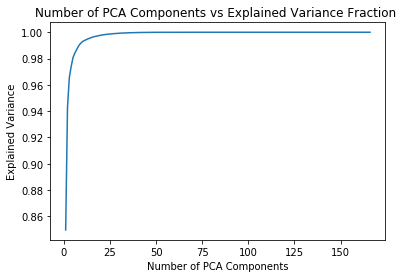

In [29]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()  

### 4. Perform Hyperparamter Tuning for PCA with 15 Components (Spectral only)

In [30]:
#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_w)
train_pca_w = pca.transform(X_train_w)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w, y_train_w.values.ravel())

print(grid.best_params_)

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'C': 0.03359818286283781, 'gamma': 0.001, 'kernel': 'linear'}


In [32]:

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w, y_train_w.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning and PCA')
print('CV Accuracy Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print('\n')
scores = cross_val_score(estimator = svm, X=train_pca_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1,scoring='f1_weighted')
print('SVM with hyperparameter tuning and PCA')
print('CV F1 Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM with hyperparameter tuning and PCA
CV Accuracy Scores:  [0.8490566  0.77358491 0.79245283 0.88461538 0.92307692]
CV Average and standard deviation:  0.8445573294629899 +/- 0.05575335257768051


SVM with hyperparameter tuning and PCA
CV F1 Scores:  [0.83207547 0.79051402 0.77742996 0.86117216 0.89986505]
CV Average and standard deviation:  0.8322113321964364 +/- 0.04506758867039811


C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


#### Observation : PCA does not reduce score but reduces number of features to just 15 principal components

### 5. Try SMOTE Algorithm to oversample minority classes and to overcome issue of of not having enough samples in those classes (Spectral only)


In [33]:
print("Before oversampling: ",Counter(y_train_w.values.ravel()))

Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6, 6: 5, 11: 4, 20: 3, 13: 3, 0: 3, 9: 3, 17: 3, 10: 2, 5: 2, 15: 2, 18: 2})


In [34]:
#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]


In [35]:
#Now print data shape
print(X_train_w_smote.shape, y_train_w_smote.shape)

(231, 167) (231, 1)


In [36]:
# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

After oversampling:  Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.808269
1                          2                              0.930429
2                          3                              0.969461
3                          4                              0.980098
4                          5                              0.985277
5                          6                              0.989432
6                          7                              0.991839
7                          8                              0.993018
8                          9                              0.994044
9                         10                              0.994901
10                        11                              0.995621
11                        12                              0.996206
12                        13                              0.996734
13                        14                              0.99

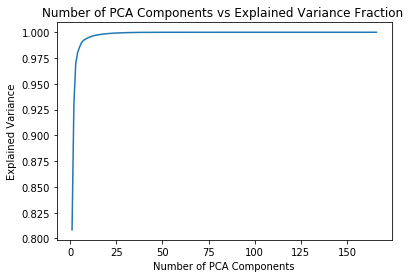

In [37]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()  

In [38]:
#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)

In [39]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

{'C': 0.012742749857031334, 'gamma': 0.001, 'kernel': 'linear'}


In [42]:
#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter, PCA and SMOTE tuning')
print('CV Accuracy Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


print('\n')
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1,scoring='f1_weighted')

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter, PCA and SMOTE tuning')
print('CV F1 Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))



SVM with hyperparameter, PCA and SMOTE tuning
CV Accuracy Scores:  [0.99555556 0.98222222 0.99111111 1.         0.99555556]
CV Average and standard deviation:  0.9928888888888888 +/- 0.006028737762778009


SVM with hyperparameter, PCA and SMOTE tuning
CV F1 Scores:  [0.99555378 0.98210771 0.99101307 1.         0.99555378]
CV Average and standard deviation:  0.9928456675208999 +/- 0.0060747722992161345


### 6. Try Data Preprocessing Techniques like Min Max Scaler or Standard Scaler (Spectral only)

In [44]:
#### MinMaxScaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMax Scaler')
print('CV Accuracy Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print('\n')

scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1,scoring='f1_weighted')

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMax Scaler')
print('CV F1 Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM with hyperparameter tuning and MinMax Scaler
CV Accuracy Scores:  [0.71111111 0.72       0.64444444 0.73777778 0.67111111]
CV Average and standard deviation:  0.6968888888888889 +/- 0.034126851236359924


SVM with hyperparameter tuning and MinMax Scaler
CV F1 Scores:  [0.6957773  0.69951192 0.62218626 0.72616119 0.64218248]
CV Average and standard deviation:  0.6771638319288827 +/- 0.03871141540985682


In [45]:
#### Standard Scaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and StandardScaler

svm = make_pipeline(StandardScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and Standard Scaler')
print('CV Accuracy Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print('\n')

scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1,scoring='f1_weighted')

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and Standard Scaler')
print('CV F1 Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


SVM with hyperparameter tuning and Standard Scaler
CV Accuracy Scores:  [0.97777778 0.96444444 0.97333333 0.97333333 0.97777778]
CV Average and standard deviation:  0.9733333333333334 +/- 0.004868644955601468


SVM with hyperparameter tuning and Standard Scaler
CV F1 Scores:  [0.97766149 0.96408409 0.97322105 0.97285624 0.97734493]
CV Average and standard deviation:  0.9730335600153477 +/- 0.00490235072573517


#### Observation : Both MinMaxScaler and StandardScalers reduce the score for the model. Do not apply this.

# SVM Scenario 2 : Baseline SVM Results with MIDI Data only

### 1. Baseline defaults with no hyperparameter tuning (MIDI Data only)

In [46]:
#Create baseline SVM model with MIDI Data only

svm = make_pipeline(SVC())
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Accuracy Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print('\n')
scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5,n_jobs=1,scoring='f1_weighted')
print('SVM Baseline with no hyperparameter tuning')
print('CV F1 Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM Baseline with no hyperparameter tuning
CV Accuracy Scores:  [0.62264151 0.66037736 0.66037736 0.65384615 0.67307692]
CV Average and standard deviation:  0.6540638606676342 +/- 0.016903423351571186


SVM Baseline with no hyperparameter tuning
CV F1 Scores:  [0.51646102 0.55334477 0.56246506 0.54090909 0.56885184]
CV Average and standard deviation:  0.5484063551528975 +/- 0.018529793914335072


C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


### 2. Find the best parameters to use via hyperparameter tuning (MIDI Data only)

In [23]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20)}
grid = GridSearchCV(SVC(), param_grid)
  
# fitting the model for grid search
grid.fit(X_train_m, y_train_m.values.ravel())

print(grid.best_params_)

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'C': 545.5594781168514}


### This model with C = 545 could not complete running after 2 hours. This is possibly because of the features makes the calculation complex.

In [ ]:
#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel='linear', C = 545.559 ))
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

### 4.  Try PCA Features to improve model speed and SMOTE Algorithm to oversample minority classes and to overcome issue of of not having enough samples in those classes (MIDI Data only)

In [47]:
print("Before oversampling: ",Counter(y_train_m.values.ravel()))

Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6, 6: 5, 11: 4, 0: 3, 9: 3, 13: 3, 17: 3, 20: 3, 5: 2, 10: 2, 15: 2, 18: 2})


In [48]:
#Drop any ensemble types with counts below 6
counts = y_train_m['ensemble'].value_counts()
X_train_m_smote = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m_smote = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]


In [49]:
#Now print data shape
print(X_train_m_smote.shape, y_train_m_smote.shape)

(231, 10) (231, 1)


In [50]:
# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_m_smote, y_train_m_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

After oversampling:  Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 14: 125, 16: 125, 19: 125})


   Number of PCA Components  Explained Fraction of Total Variance
0                         1                              0.904859
1                         2                              1.000000
2                         3                              1.000000
3                         4                              1.000000
4                         5                              1.000000
5                         6                              1.000000
6                         7                              1.000000
7                         8                              1.000000
8                         9                              1.000000


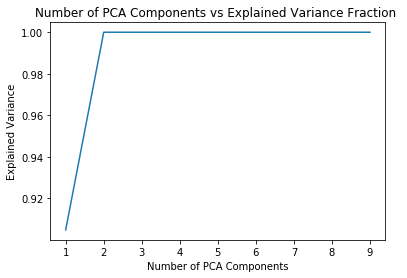

In [51]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,10)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_m_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 9 i.e. one less than 10
all_possible_k = np.arange(1,10)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_m_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()  

In [52]:
#Perform PCA with 2 components
pca=PCA(n_components = 2)
pca.fit(X_SMOTE)
train_pca_m_smote = pca.transform(X_SMOTE)

In [25]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20)} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_m_smote, y_SMOTE)

print(grid.best_params_)

{'C': 10000.0}


In [ ]:
#Create SVM model with best hyperparameters and SMOTE

svm = make_pipeline(SVC(kernel='linear', C = grid.best_params_['C'] ))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter and SMOTE tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

In [ ]:
#### MinMaxScaler Application

#Create SVM model with best hyperparameters,SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C'] ))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMaxScaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

In [ ]:
#### StandardScaler Application

#Create SVM model with best hyperparameters,  SMOTE and StandardScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C']))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and StandardScaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### Models on MIDI Data could not be run due to long runtime (4 hours) for linear, rbf and polynomial kernels. 

#### One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well. 


# SVM Scenario 3 : Baseline SVM Results with Combined MIDI Data and Wav Spectral Features 

### 1. Baseline defaults with no hyperparameter tuning (Combined Data)

In [53]:
#Create baseline SVM model with Spectral Wav and MIDI Data

svm = make_pipeline(SVC())
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Accuracy Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print('\n')
scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5,n_jobs=1,scoring='f1_weighted')
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM Baseline with no hyperparameter tuning
CV Accuracy Scores:  [0.62264151 0.64150943 0.66037736 0.65384615 0.67307692]
CV Average and standard deviation:  0.6502902757619738 +/- 0.017176625192111616


SVM Baseline with no hyperparameter tuning
CV Scores:  [0.52166317 0.53576117 0.56246506 0.54090909 0.56640591]
CV Average and standard deviation:  0.5454408798957261 +/- 0.016786712183155014


C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


### 2. Find the best parameters to use via hyperparameter tuning (Combined Data)

In [ ]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_c, y_train_c.values.ravel())

print(grid.best_params_)

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

### 3. Try PCA to reduce features (Combined Data)

In [ ]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 175 i.e. one less than 176
all_possible_k = np.arange(1,176)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()  

In [ ]:
#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_c)
train_pca_c = pca.transform(X_train_c)

In [ ]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_c, y_train_c.values.ravel())

print(grid.best_params_)

In [ ]:

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_c, y_train_c.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning and PCA')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### Note the models could not complete the run for combined data hyperparameter tuning and model run when midi features were added. 

# Conclusion :

- The MIDI data and Data Set containing MIDI data could not complete running on the SVM model.

- One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well.

- In conclusion, the best SVM model was run on spectral data and has a 5-fold cross-validation accuracy score of 98% and F1 score of 98%, and standard deviation of 0.005 when a cross validation was done on training/dev data,

- It has PCA with 15 components, SMOTE application to balance the sample classes and also hyperparameter tuning where we found the best C, best gamma and also that linear kernel is the best kernel to use amongst the 3 types that are available.

- When run on test data, the best SVM model had an F1 Score of 72%.

### Best SVM Model using Spectral Data

In [10]:
#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

test_pca_w = pca.transform(X_test_w)
predictions_pca_w = svm.predict(test_pca_w)


{'C': 0.012742749857031334, 'gamma': 0.001, 'kernel': 'linear'}


In [12]:
print('Accuracy score: ', accuracy_score(np.array(y_test_w),predictions_pca_w))
print('F1 Score: ', f1_score(np.array(y_test_w), predictions_pca_w, average='weighted'))
print('Classification report: \n', classification_report(np.array(y_test_w), predictions_pca_w))
print('Confusion Matrix: \n', confusion_matrix(np.array(y_test_w), predictions_pca_w))

Accuracy score:  0.7575757575757576
F1 Score:  0.7158622472055307
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.83      0.97      0.90        31
           2       0.00      0.00      0.00         1
           4       0.91      0.91      0.91        11
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         1
          14       0.67      1.00      0.80         2
          15       0.00      0.00      0.00         1
          16       0.67      1.00      0.80         2
          17       0.00      0.00      0.00 

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
